In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from football_sim import *
plt.rcParams['figure.figsize']=[32,18]

In [2]:
urls = {'EN': 'http://www.football-data.co.uk/mmz4281/1718/E0.csv',
                          'ES': 'http://www.football-data.co.uk/mmz4281/1718/SP1.csv',
                          'IT': 'http://www.football-data.co.uk/mmz4281/1718/I1.csv',
                          'FR': 'http://www.football-data.co.uk/mmz4281/1718/F1.csv',
                          'DE': 'http://www.football-data.co.uk/mmz4281/1718/D1.csv',
                          'NL': 'http://www.football-data.co.uk/mmz4281/1718/N1.csv'
                          }


In [3]:
all_data=get_data(urls)

In [4]:
teams = create_teams(all_data)

In [5]:
teams=calibrate(teams,all_data)

In [6]:
EnglishTeams={x:teams[x] for x in teams if teams[x].country=='EN'}
PremierLeague=Season(EnglishTeams)
PremierLeague.process_current_results(all_data['EN'])
PremierLeague.simulate_season(n_scenarios=100000)

In [7]:
PremierLeague.season_report()

simulation not yet processed, processing


,Points (mean),Points (low),Points (high),Place (low),Place (high),Win,CL,Off,Deff,Degr
Man City,98.0,92.0,103.0,1.0,1.0,99.95,100.00,2.27,0.19,0.00
Man United,79.6,73.0,86.0,5.0,2.0,0.04,93.52,1.27,0.14,0.00
Liverpool,78.1,71.0,84.0,5.0,2.0,0.01,90.56,1.69,0.28,0.00
Chelsea,74.0,67.0,81.0,6.0,2.0,0.00,54.56,1.13,0.19,0.00
Tottenham,73.7,67.0,80.0,6.0,2.0,0.00,57.04,1.37,0.20,0.00
Arsenal,66.2,59.0,73.0,6.0,5.0,0.00,4.31,1.35,0.58,0.00
Burnley,54.7,48.0,62.0,9.0,7.0,0.00,0.00,0.34,0.16,0.00
Leicester,53.3,46.0,60.0,9.0,7.0,0.00,0.00,0.87,0.57,0.00
Bournemouth,45.5,39.0,53.0,14.0,8.0,0.00,0.00,0.62,0.73,0.37
Everton,44.4,38.0,51.0,16.0,8.0,0.00,0.00,0.48,0.92,1.22


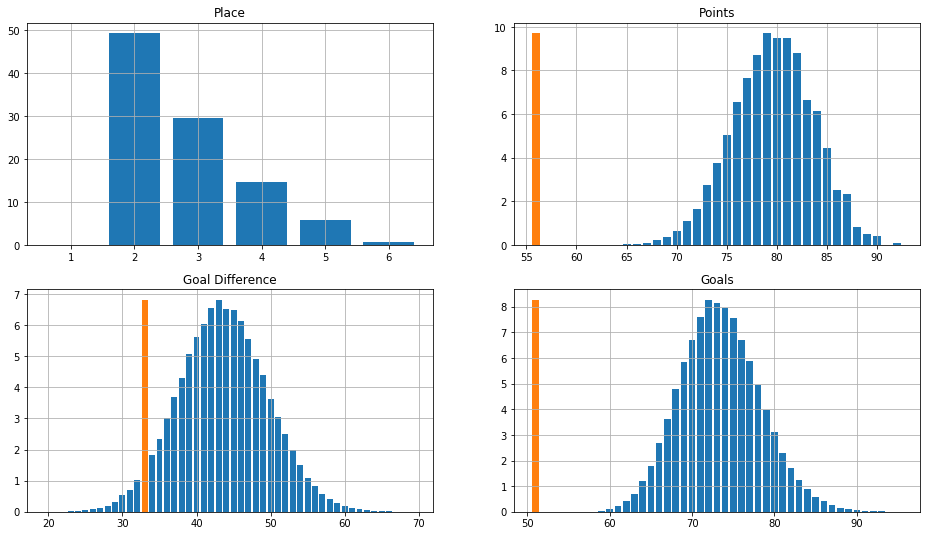

In [8]:
PremierLeague.team_report('Man United')

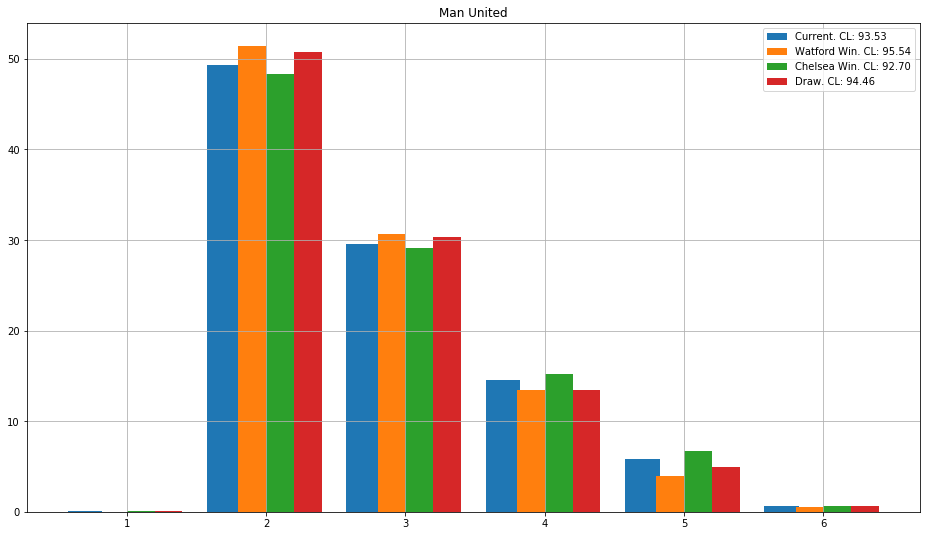

In [9]:
PremierLeague.what_if('Watford v Chelsea',ref_team='Man United')

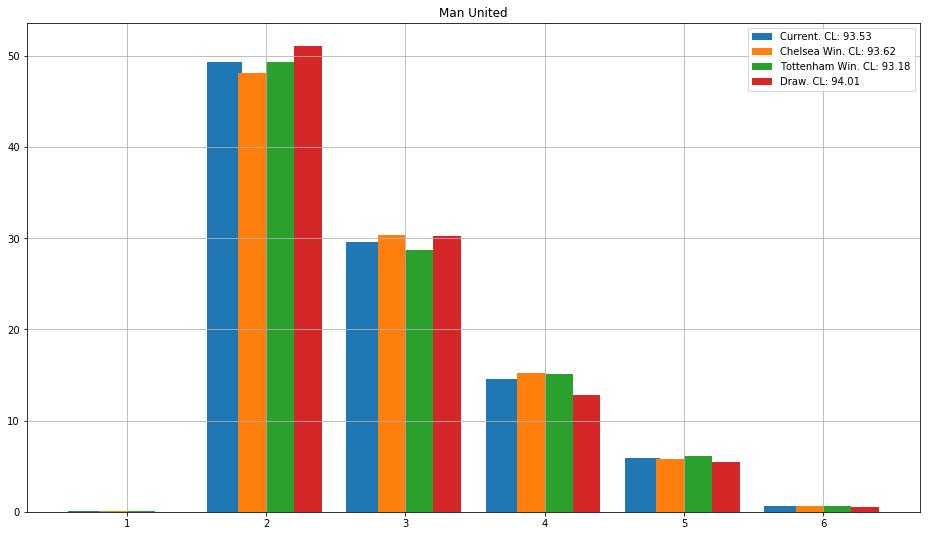

In [10]:
PremierLeague.what_if('Chelsea v Tottenham',ref_team='Man United')

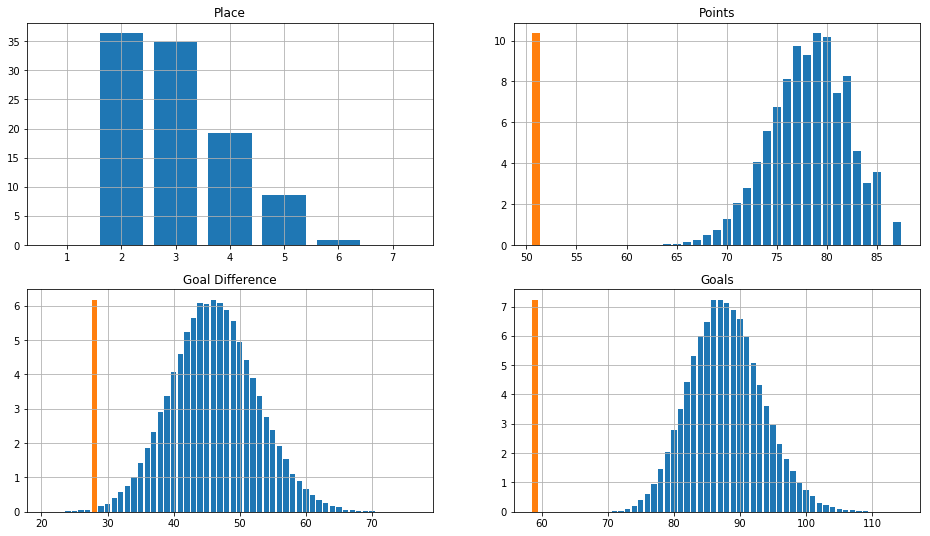

In [11]:
PremierLeague.team_report('Liverpool')

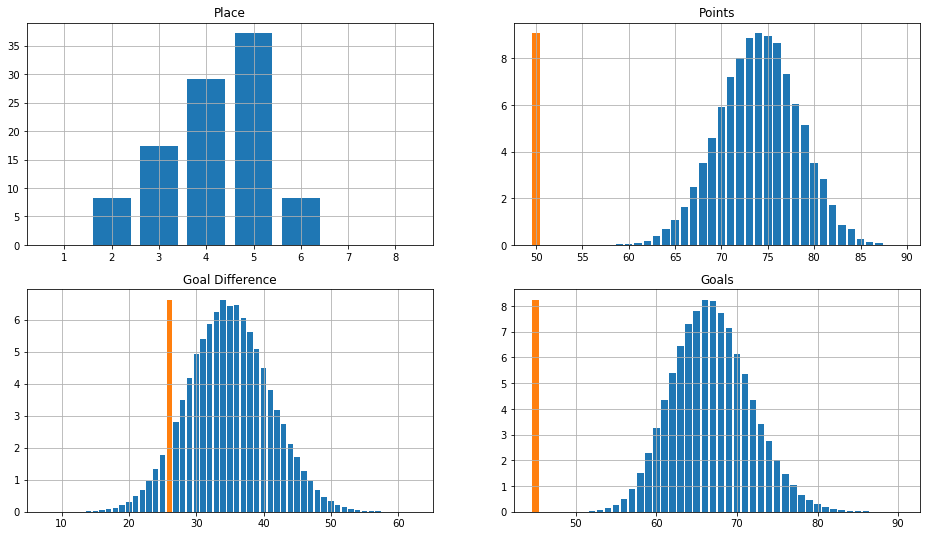

In [12]:
PremierLeague.team_report('Chelsea')

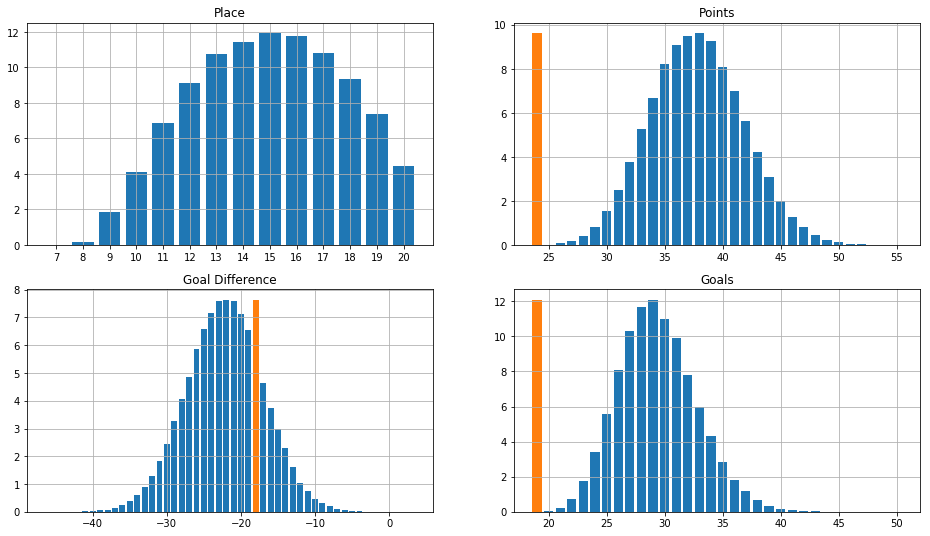

In [13]:
PremierLeague.team_report('Swansea')

In [14]:
TeamSet={x:teams[x] for x in teams if teams[x].means()[0]>=1 and teams[x].country=='EN'}
#GoodTeams={x:teams[x] for x in teams if teams[x].means()[0]>=1.2}

In [15]:
CustomLeague=Season(TeamSet,nr_cl=2,nr_degr=1)
CustomLeague.process_current_results(all_data['EN'])
CustomLeague.process_current_results(all_data['ES'])
CustomLeague.process_current_results(all_data['DE'])
CustomLeague.process_current_results(all_data['NL'])
CustomLeague.process_current_results(all_data['FR'])
CustomLeague.process_current_results(all_data['IT'])
CustomLeague.simulate_season(n_scenarios=100000)

simulation not yet processed, processing


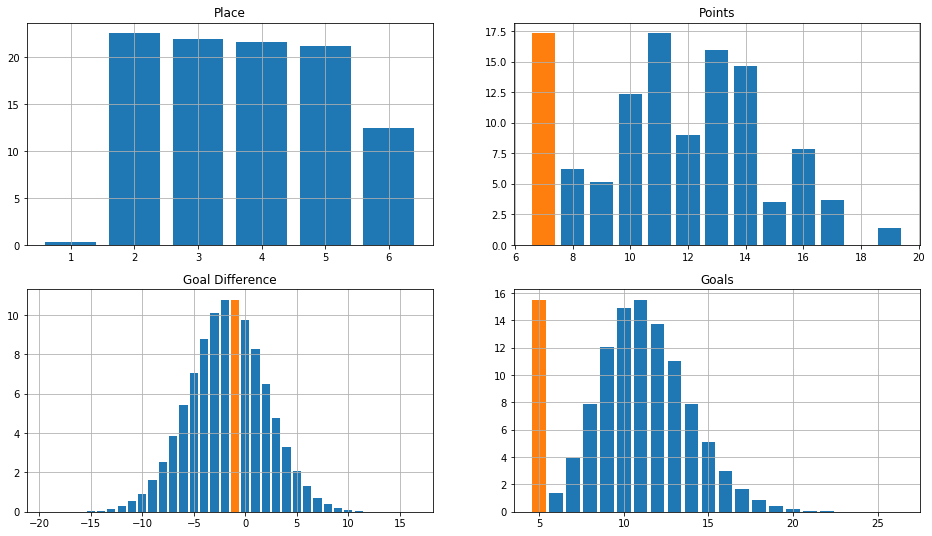

In [16]:
CustomLeague.team_report('Man United')

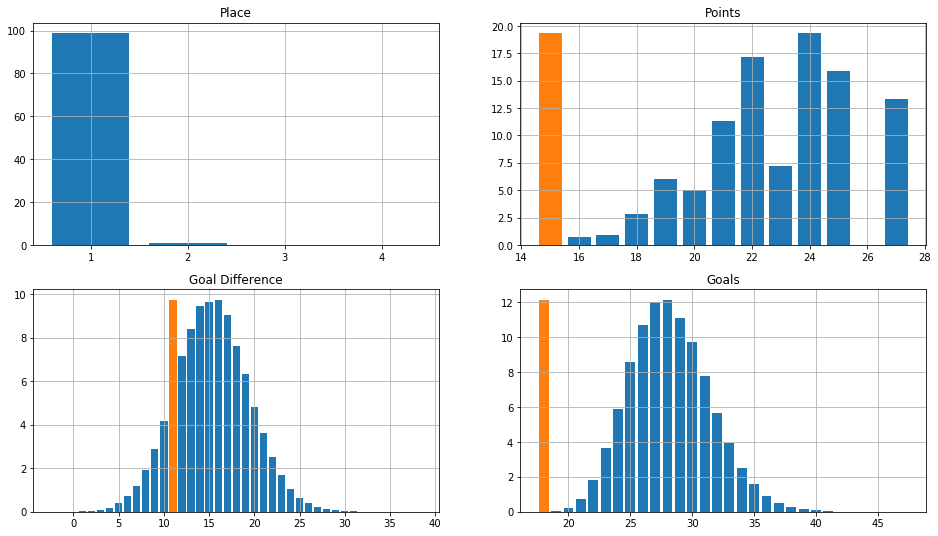

In [17]:
CustomLeague.team_report('Man City')

In [18]:
CustomLeague.season_report()

,Points (mean),Points (low),Points (high),Place (low),Place (high),Win,CL,Off,Deff,Degr
Man City,23.0,19.0,27.0,1.0,1.0,98.82,99.90,2.27,0.19,0.00
Chelsea,13.4,9.0,18.0,5.0,2.0,0.77,35.10,1.13,0.19,4.55
Liverpool,13.2,10.0,16.0,5.0,2.0,0.04,31.16,1.69,0.28,2.10
Man United,12.2,8.0,17.0,6.0,2.0,0.32,22.86,1.27,0.14,12.40
Tottenham,11.1,7.0,14.0,6.0,2.0,0.04,9.78,1.37,0.20,19.01
Arsenal,9.1,6.0,13.0,6.0,3.0,0.00,1.19,1.35,0.58,61.94


In [19]:
SpanishTeams={x:teams[x] for x in teams if teams[x].country=='ES'}
LaLiga=Season(SpanishTeams)
LaLiga.process_current_results(all_data['ES'])
LaLiga.simulate_season(n_scenarios=100000)

In [20]:
LaLiga.season_report()

simulation not yet processed, processing


,Points (mean),Points (low),Points (high),Place (low),Place (high),Win,CL,Off,Deff,Degr
Barcelona,96.6,89.0,103.0,1.0,1.0,99.83,100.00,2.03,0.11,0.00
Ath Madrid,77.4,69.0,85.0,4.0,2.0,0.15,99.25,0.74,0.09,0.00
Real Madrid,71.8,63.0,80.0,5.0,2.0,0.01,92.67,1.38,0.42,0.00
Valencia,69.8,61.0,78.0,5.0,2.0,0.00,85.86,1.25,0.46,0.00
Villarreal,61.4,53.0,70.0,10.0,4.0,0.00,14.53,0.78,0.45,0.00
Sevilla,55.6,47.0,64.0,13.0,5.0,0.00,1.84,0.67,0.54,0.00
Celta,55.2,47.0,64.0,13.0,5.0,0.00,2.13,1.11,0.82,0.00
Girona,54.4,46.0,63.0,14.0,5.0,0.00,1.20,0.71,0.51,0.00
Eibar,54.0,46.0,62.0,14.0,5.0,0.00,1.10,0.83,0.72,0.00
Getafe,52.7,45.0,61.0,14.0,6.0,0.00,0.57,0.59,0.37,0.01


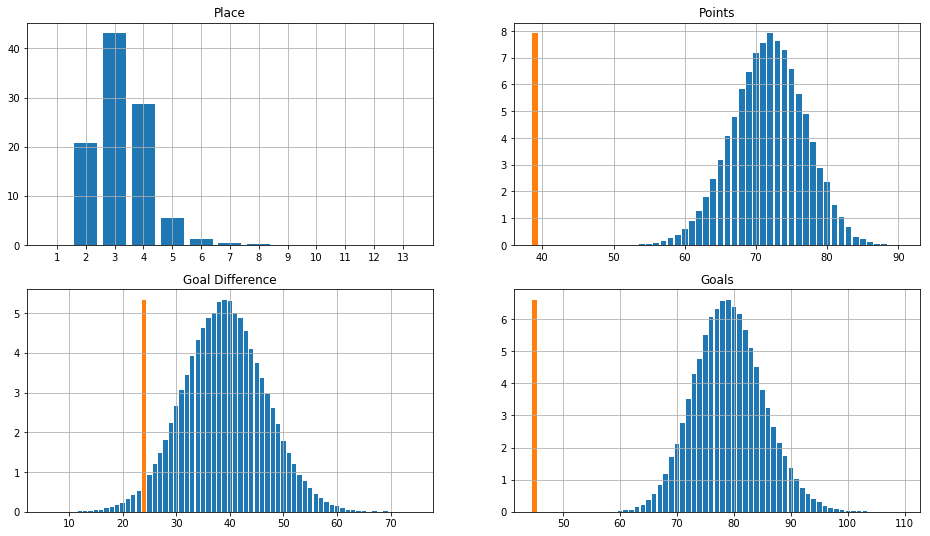

In [21]:
LaLiga.team_report('Real Madrid')

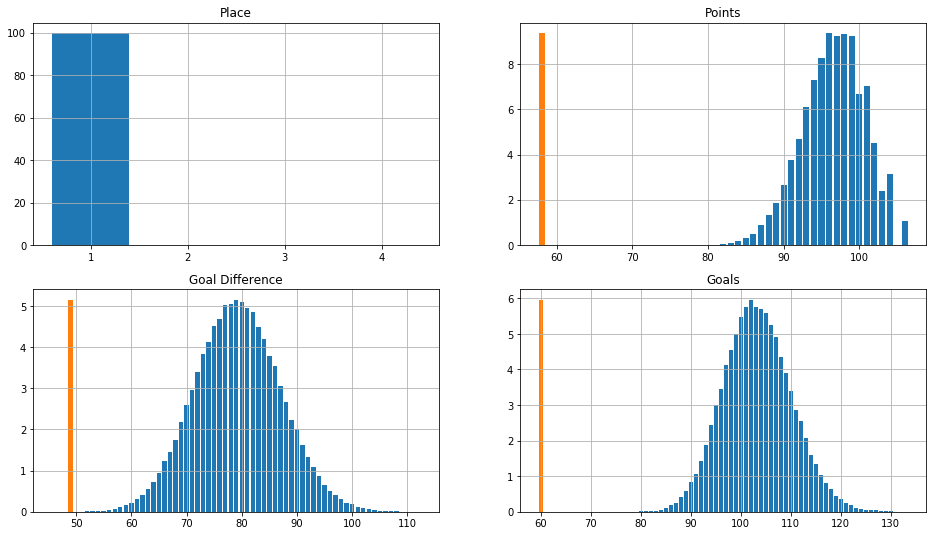

In [22]:
LaLiga.team_report('Barcelona')